In [1]:
%env CUDA_VISIBLE_DEVICES=0
import numpy as np
import torch
import h5py
import pylab as plt
plt.style.use('dark_background')
import nibabel

env: CUDA_VISIBLE_DEVICES=0


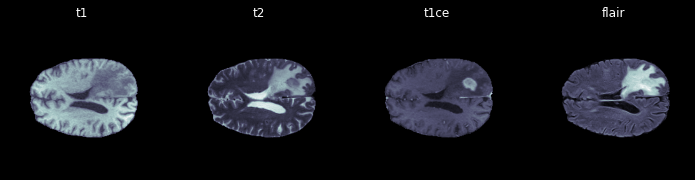

In [2]:
image = {}
for i, m in enumerate(['t1', 't2', 't1ce', 'flair']):
    data = nibabel.load(f'/home/orogov/brats/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_{m}.nii')
    image[m] = torch.from_numpy(data.dataobj[:, :, 85].copy()).float()
    image[m] /= image[m].max() 
    
plt.figure(figsize=(10,2.5))
for i, m in enumerate(['t1', 't2', 't1ce', 'flair']):  
    plt.subplot(141 + i)
    plt.title(m)
    plt.imshow(image[m], cmap=plt.cm.bone)
    plt.axis('off')
plt.tight_layout()
plt.show()

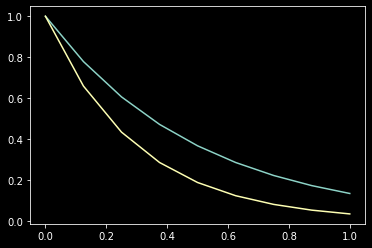

In [3]:
times = torch.linspace(1e-11, 1.0, 9)
t1 = 0.5
t2 = 0.3
plt.plot(times, (-times / t1).exp())
plt.plot(times, (-times / t2).exp())
plt.show()

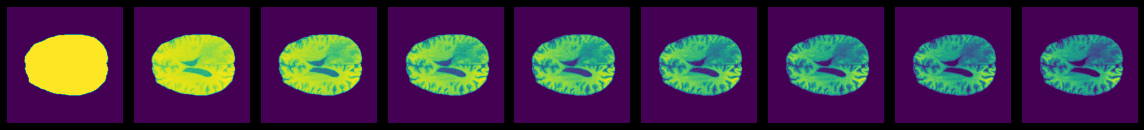

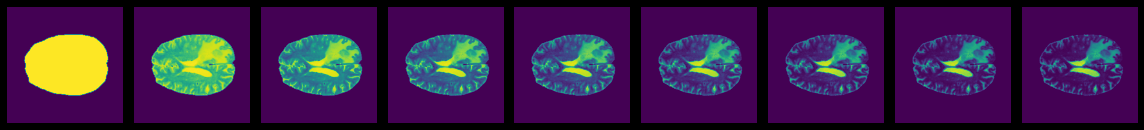

In [7]:
plt.figure(figsize=(16, 4))
for i in range(9):
    plt.subplot(191 + i)
    plt.imshow((-times[:, None, None] / image['t1'] + 1e-11).exp()[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4))
for i in range(9):
    plt.subplot(191 + i)
    plt.imshow((-times[:, None, None] / image['t2'] + 1e-11).exp()[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
pd = torch.ones_like(image['t1']).cuda()
pd = torch.nn.Parameter(data=pd, requires_grad=True)
optim = torch.optim.Adam([pd], lr=1e-3)

from tqdm import tqdm
pbar = tqdm(range(1000))
for _ in pbar:
    r0 = (-times[:, None, None].cuda() * (pd + 1e-11) / image['t1'].cuda() + 1e-11).exp()[0]
    r1 = (-times[:, None, None].cuda() * (pd + 1e-11) / image['t2'].cuda() + 1e-11).exp()[0]
    loss = (r0 - r1).abs().mean()
    pbar.set_description(f'{loss.item()}')
    loss.backward()
    pd.grad.data = torch.nan_to_num(pd.grad.data, 0)
    optim.step()
    optim.zero_grad()

0.00039128391654230654: 100%|██████████| 1000/1000 [00:02<00:00, 458.19it/s]


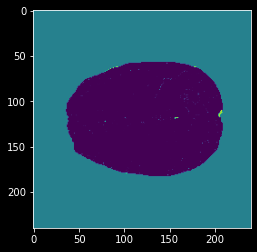

In [13]:
plt.imshow(pd.cpu().data)